# Modeling emission inequality

This notebook introduces a simple model of the connection between inequality and well-being under a limited emission budget.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Global emission shares

As input data, we use the total emissions of each percentile of the global population of 2019, taken from the [World Inequality Database](https://wid.world/).

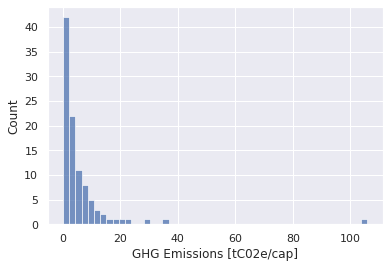

In [53]:
emissions = pd.read_csv(f'data/tco2e_cap_2019.csv')['value'].to_numpy()
ax = sns.histplot(emissions)
ax.set_xlabel('GHG Emissions [tC02e/cap]');

Let's calculate the average emissions per capita:

In [33]:
np.sum(emissions) / len(emissions)

6.054784140437841

We define a function that can redistribute emissions between each percentile.

In [17]:
def redist(x, p):
    """ Redistribute values x by a percentage p in [0, 1]. """
    y = np.sum(x * p) / len(x)
    return x - x * p + y

For example, the following represents a redistribution by 50%.

In [18]:
redist_emissions = redist(emissions, 0.5)

We can measure and compare the inequality of different distributions with the Gini coefficient, as defined [here](https://stackoverflow.com/a/39513799).

In [19]:
def gini(x):
    """ Takes a list of values and returns the Gini coefficient. """
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad    

print(f"Gini coefficient before redistribution: {gini(emissions)}")
print(f"Gini coefficient after redistribution: {gini(redist_emissions)}")

Gini coefficient before redistribution: 0.604236865070486
Gini coefficient after redistribution: 0.3021184325352431


## The model

We can now define our model. We make the following assumptions:

- The model consists of 100 people, each representing 1% of the global population.
- Peoples initial emissions reflect global data from 2019.
- Peoples emissions are reduced proportionally to stay within a target `emissions_max`.
- Peoples emissions are then subjected to a certain level of `redistribution`.
- There is a a minimum amount of emissions `emissions_min` that is needed to live a good life.

The following function can calculate the share of people living a good life, given parameters of `min_share` and `redistribution`.

In [54]:
def calc_good_life_share(emissions_min, redistribution, emissions_max):

    emissions = pd.read_csv(f'data/tco2e_cap_2019.csv')['value'].to_numpy()
    reduced_emissions = emissions * emissions_max * 100 / np.sum(emissions)
    redist_emissions = redist(reduced_emissions, redistribution)
    n_good_life = sum([res >= emissions_min for res in redist_emissions]) 
    
    return n_good_life / 100

We now define an experiment with this model, using different parameter values.

In [55]:
def run_experiment(emissions_min_range, redistribution_range, emissions_max):

    results = []
    for emissions_min in np.linspace(*emissions_min_range, 10):
        for redistribution in np.linspace(*redistribution_range, 10):
            gls = calc_good_life_share(emissions_min, redistribution, emissions_max)
            results.append([gls, emissions_min, redistribution])

    columns = ['good_life_share', 'emissions_min', 'redistribution']
    return pd.DataFrame(results, columns=columns)

Finally, we define a function to visualize the results of this experiment, using the seaborn and matplotlib libraries.

In [72]:
def plot_simulation(results, emissions_min_range, emissions_max):
    
    # Main plot
    ax = sns.lineplot(
        data=results, 
        x='redistribution', 
        y='good_life_share', 
        hue='emissions_min',
        palette='cool',
    )
    
    # Labels
    ax.set_title(f'Emission target: {emissions_max} tCO2e/cap')
    ax.set_xlabel('Redistribution of emissions')
    ax.set_ylabel('Share of people with a good life')
    
    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap='cool', 
        norm=plt.Normalize(*emissions_min_range))
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm)
    cbar.ax.get_yaxis().labelpad = 40
    cbar.set_label('Emissions needed for a good life\n [tCO2e/cap]', rotation=270)

## Results and discussion

We can now run and visualize the experiment for different parameter ranges as follows:

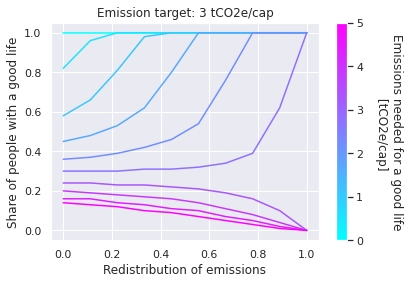

In [74]:
emissions_max = 3
emissions_min_range = (0, 5)
redistribution_range = (0, 1)
results = run_experiment(emissions_min_range, redistribution_range, emissions_max)
plot_simulation(results, emissions_min_range, emissions_max)

**Questions for discussion**:

- What level of emission reduction is represented by the chosen value of `emissions_max`?
- Why does more redistribution lead to a higher (lower) `good_life_share` for lower (higher) values of `emission_min`?
- What happens under different parameter choices?
- What does `emission_min` represent in the real world?
- What kind of knowledge can we gain (or not gain) from this model?